In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.fft import fft
from scipy.fft import ifft
from scipy.signal import get_window
import matplotlib.pyplot as plt


## Processing accelerometer data

Input: Raw time signal (time domain)

Output: Time & Frequency domain

<br>


1: Divide all signals into 10s time windows (consecutive non-overlapping). Try each signal separately? 1hz low sampling freq. try full data?


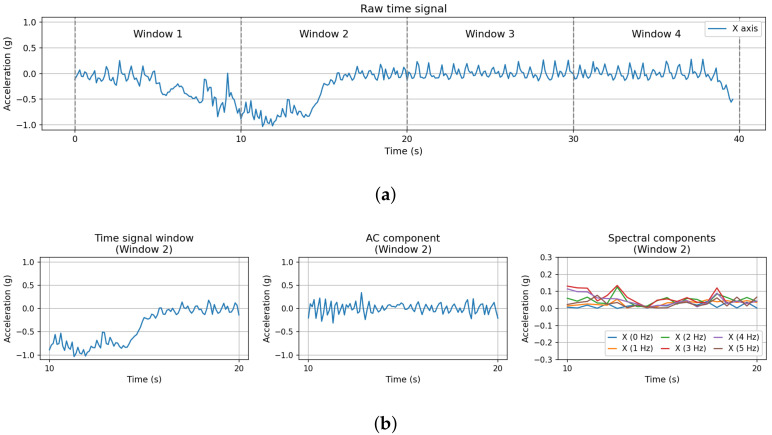

In [5]:
data = pd.read_csv('datasets/pos_A.csv', dtype={'label': str}, na_values='null', low_memory=False)

filtered_data = data[['ax', 'ay', 'az', 'label', 'animal_ID', 'timestamp_ms']]
data25 = filtered_data.iloc[::4, :].copy() #downsample 100Hz data to 25Hz data

#data25['timestamp_s'] = data25['timestamp_ms'] / 1000

# Calculate window index for each sample
# Each window is 10 seconds long. Divide timestamp by 10 and take floor to find window index.
data25['window_index'] = data25['timestamp_ms'] // 10000

# Group data by window_index, and then split into individual windows
windows = [window for _, window in data25.groupby('window_index')]

data25.to_csv('datasets/filtered_data_25hz.csv', index=False)


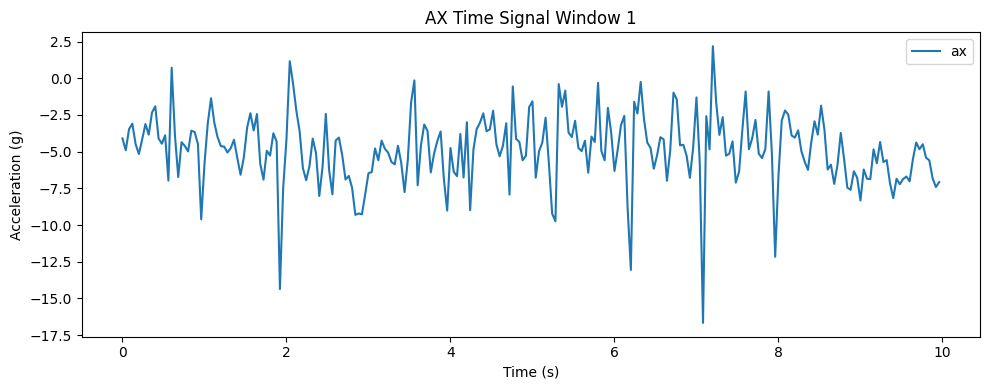

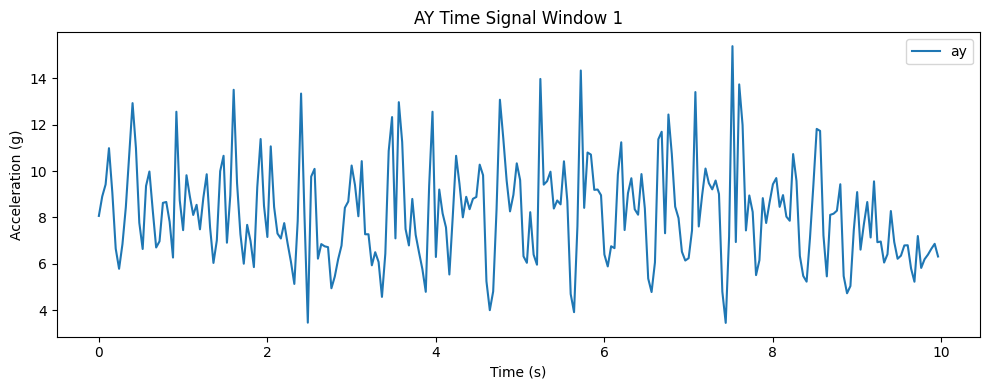

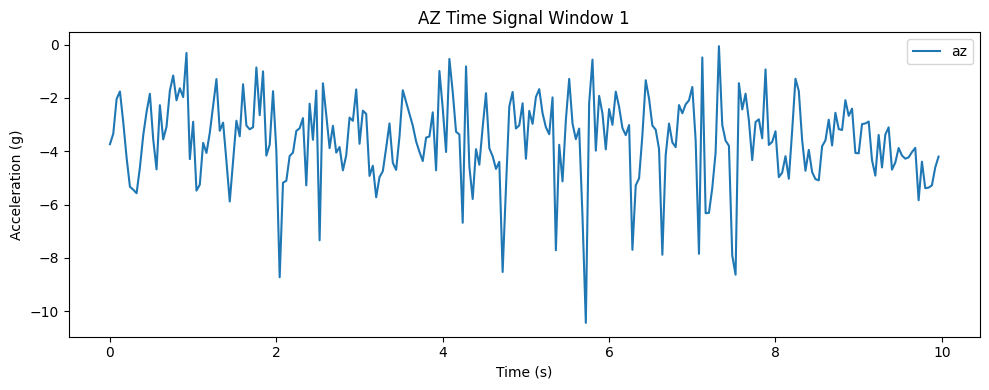

In [6]:

# Determine the number of samples per window (10 seconds * 100 Hz)
samples_per_window = 10 * 25

# Calculate the total number of windows
total_windows = len(data25) // samples_per_window


# Plotting each window for each axis
for axis in ['ax', 'ay', 'az']:
    for window in range(total_windows):
        if window == 0:
            # Select the data for the current window
            start_idx = window * samples_per_window
            end_idx = start_idx + samples_per_window
            data_window = data25.iloc[start_idx:end_idx]
            
            # Create a plot for the current window
            plt.figure(figsize=(10, 4))
            plt.plot(data_window['timestamp_ms'] / 1000, data_window[axis], label=axis)
            
            # Adding title and labels
            plt.title(f'{axis.upper()} Time Signal Window {window + 1}')
            plt.xlabel('Time (s)')
            plt.ylabel('Acceleration (g)')
            plt.legend()
            plt.tight_layout()
            plt.show()


## Feature extraction

In [7]:
# Initialize a list to hold the AC components for each window
windows_ac = []

for window in windows:
    # Calculate DC components (mean values) for ax, ay, and az
    dc_ax = window['ax'].mean()
    dc_ay = window['ay'].mean()
    dc_az = window['az'].mean()
    
    # Calculate AC components by subtracting DC component from each signal
    window['ac_ax'] = window['ax'] - dc_ax
    window['ac_ay'] = window['ay'] - dc_ay
    window['ac_az'] = window['az'] - dc_az
    window['jerk_ax'] = window['ax'].diff().fillna(0)
    window['jerk_ay'] = window['ay'].diff().fillna(0)
    window['jerk_az'] = window['az'].diff().fillna(0)
    #More?

    
    # Append the window with AC components to the list
    windows_ac.append(window)

# Now, windows_ac contains each window with additional columns for the AC components of ax, ay, and az


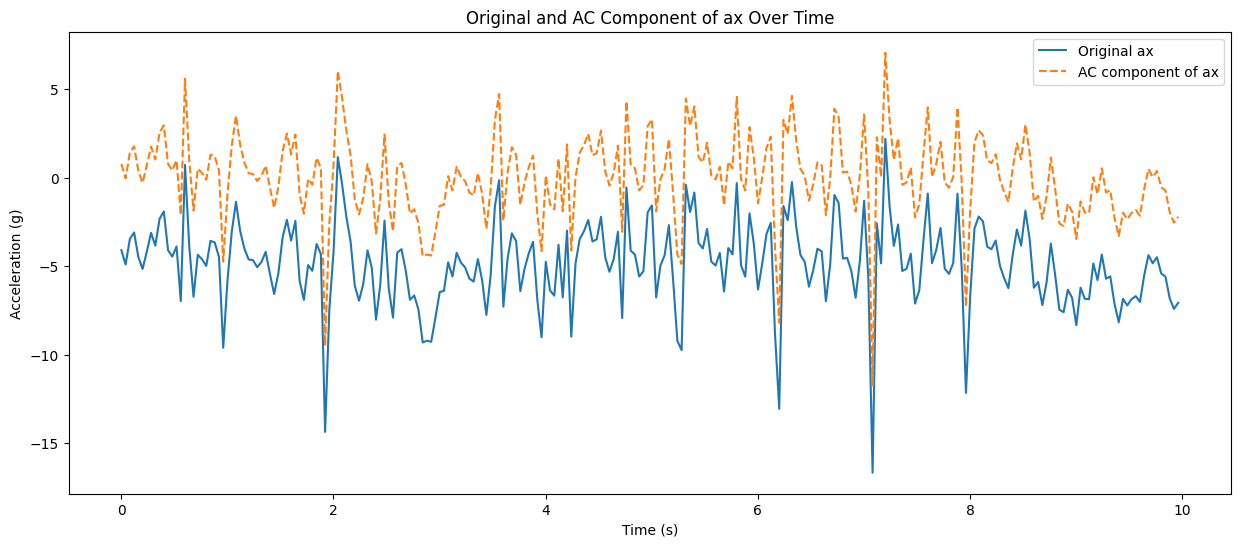

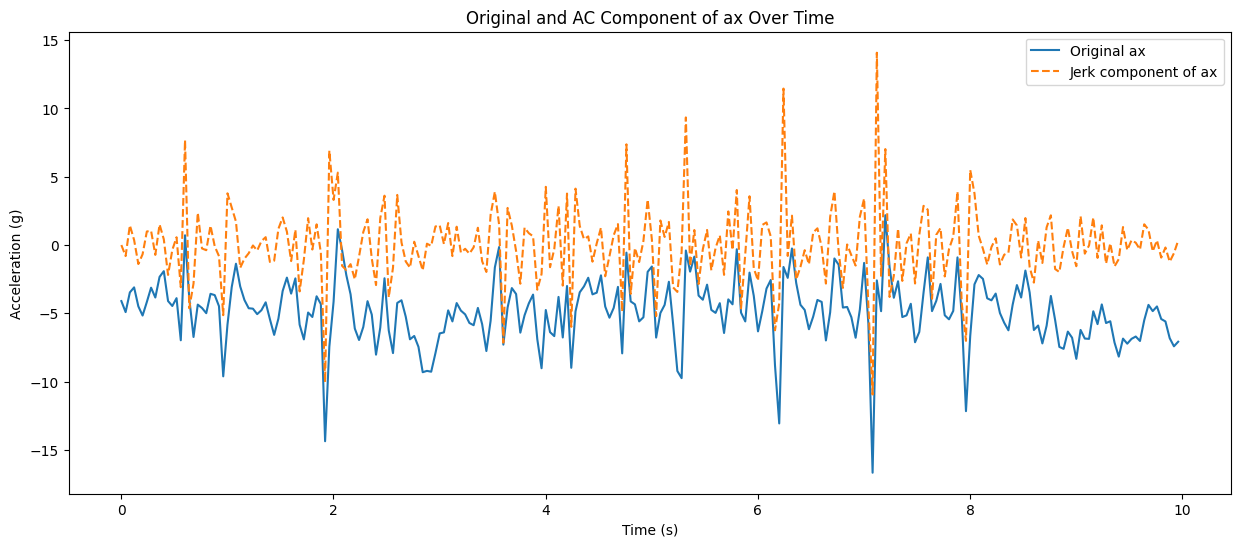

In [8]:

# Assuming windows_ac[0] contains 'ax' and its AC component 'ac_ax'
plt.figure(figsize=(15, 6))
plt.plot(windows_ac[0]['timestamp_ms'] / 1000, windows_ac[0]['ax'], label='Original ax')
plt.plot(windows_ac[0]['timestamp_ms'] / 1000, windows_ac[0]['ac_ax'], label='AC component of ax', linestyle='--')

# Adding title and labels
plt.title('Original and AC Component of ax Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()

# Display the plot
plt.show()

# Assuming windows_ac[0] contains 'ax' and its AC component 'ac_ax'
plt.figure(figsize=(15, 6))
plt.plot(windows_ac[0]['timestamp_ms'] / 1000, windows_ac[0]['ax'], label='Original ax')
plt.plot(windows_ac[0]['timestamp_ms'] / 1000, windows_ac[0]['jerk_ax'], label='Jerk component of ax', linestyle='--')

# Adding title and labels
plt.title('Original and AC Component of ax Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()

# Display the plot
plt.show()



1. Divide the AC component into 1-second windows: Since your data is sampled at 25 Hz, a 1-second window will contain 25 samples.

2. Apply the Hanning window function: This is a windowing function used to reduce the spectral leakage before performing the FFT.

3. Compute the FFT for each window: Perform the FFT on each windowed segment of the AC component.

4. Handle 50% overlap: When moving to the next window, you start at the halfway point of the current window, which means each window will overlap the previous one by 50%.

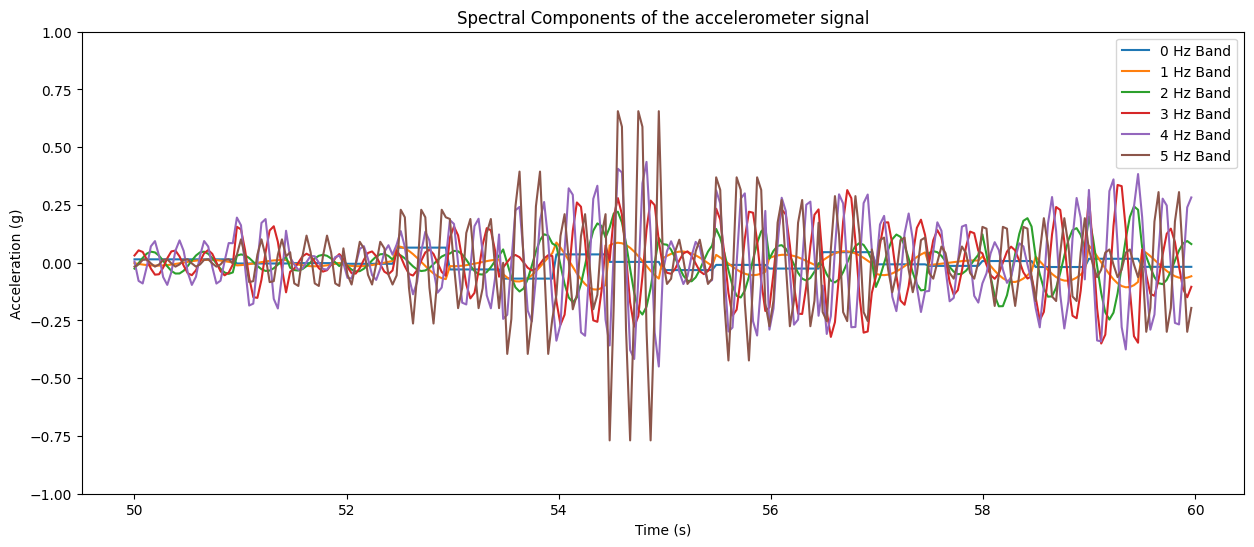

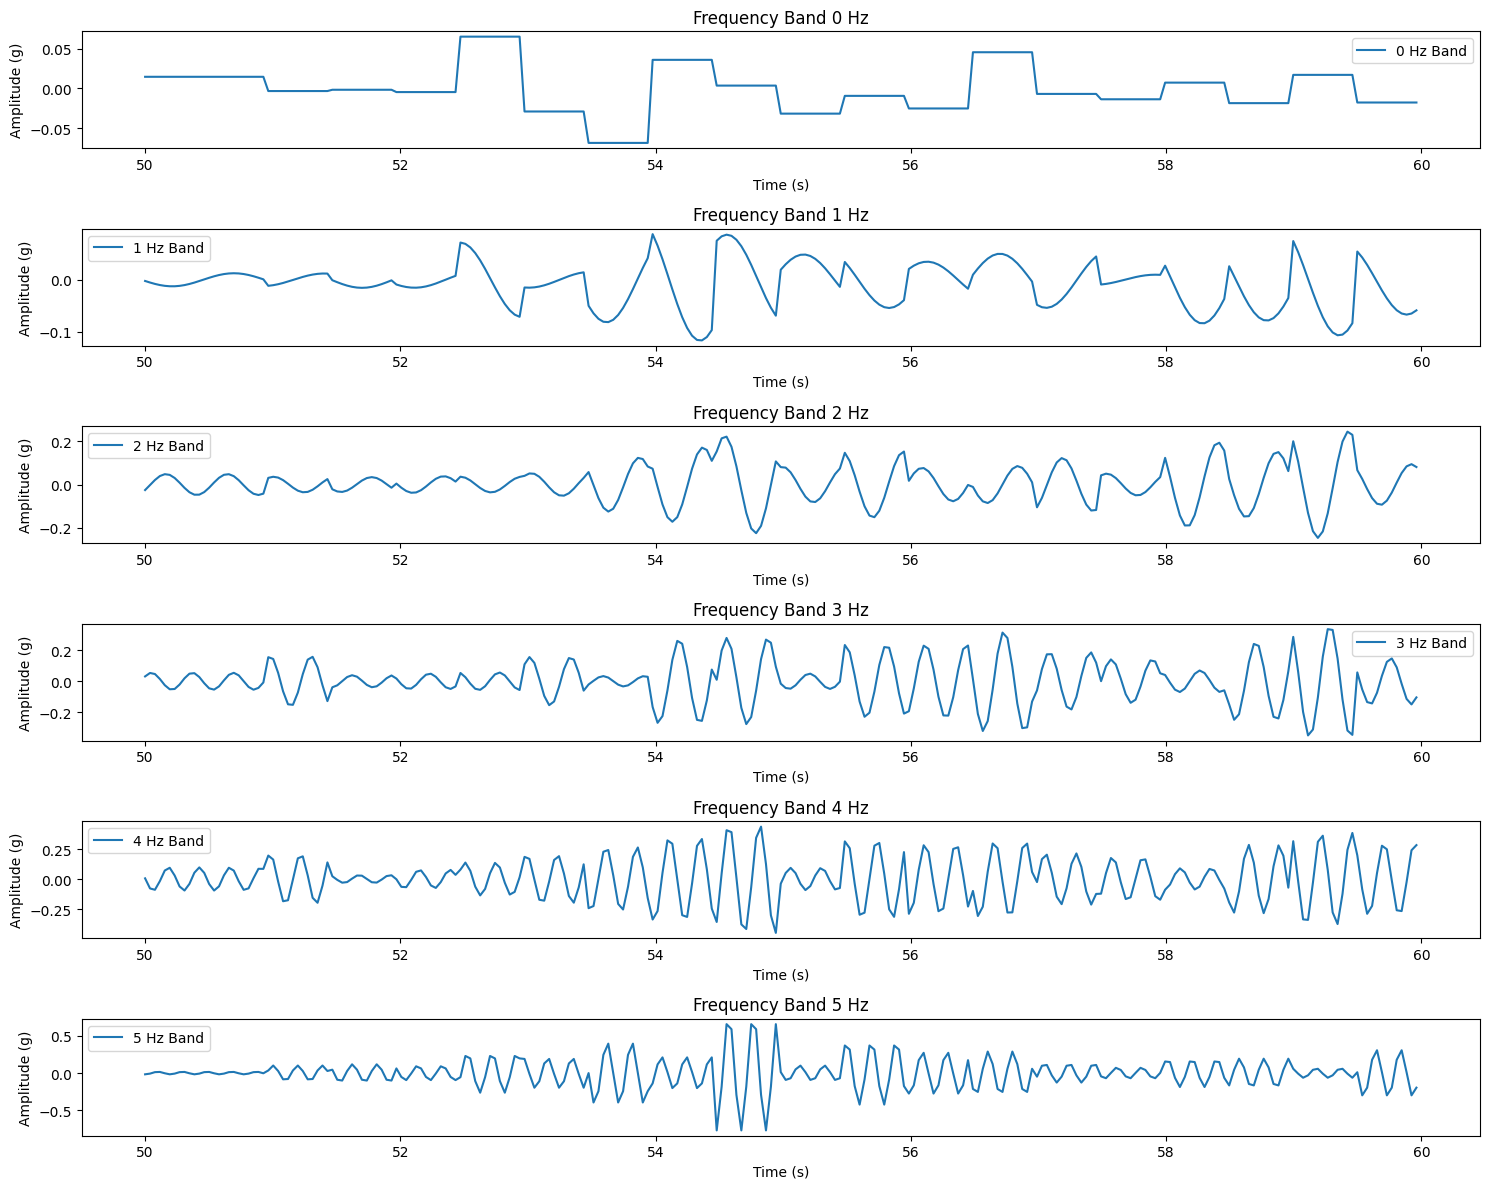

In [9]:
#find components of one 10s window

windowID = 5
if windowID != None:
    ac_component_10s = windows_ac[windowID]['jerk_ax'].to_numpy()  

# Define the window size, overlap, and sampling rate for 1-second windows
sampling_rate = 25  # 25 Hz sampling rate
window_size = sampling_rate * 1  # 1-second window for 1 Hz resolution
overlap = window_size // 2  # 50% overlap

# Prepare a Hanning window
hann_window = get_window('hann', window_size)

# Initialize an empty list to store the FFT results
fft_results = []

# Initialize a dictionary to store the time-domain signals for each frequency band
time_domain_signals = {f: [] for f in range(6)}  # 0 Hz to 5 Hz

# Iterate over the 10-second segment with 1-second windows and 50% overlap
for i in range(0, len(ac_component_10s) - window_size + 1, overlap):
    # Extract the 1-second window and apply the Hanning window
    window_data = ac_component_10s[i:i+window_size]
    windowed_data = window_data * hann_window
    
    # Compute the FFT
    fft_result = fft(windowed_data, n=window_size)
    
    # Perform IFFT for each of the first 6 frequency bins (0 to 5 Hz)
    for f in range(6):
        isolated_fft = np.zeros_like(fft_result)
        isolated_fft[f] = fft_result[f]
        
        # Perform IFFT to get the time-domain signal
        time_signal = ifft(isolated_fft, n=window_size).real
        
        # Store the time-domain signal
        time_domain_signals[f].append(time_signal[:window_size])

# Concatenate the overlapping windows for each frequency band
for f in time_domain_signals:
    # Overlapping by half window size means we take the second half from each window
    concatenated_signal = [time_domain_signals[f][0]]
    for segment in time_domain_signals[f][1:]:
        concatenated_signal.append(segment[overlap:])
    time_domain_signals[f] = np.concatenate(concatenated_signal)



if(windowID != None):
    # Create a time vector for the x-axis that covers 10 seconds
    time_vector = np.linspace(0, 10, num=len(time_domain_signals[0]), endpoint=False)

    # Plot each frequency band's signal
    plt.figure(figsize=(15, 6))
    a, b = -1, 1
    plt.ylim((a, b))

    for f in range(6):
        plt.plot(time_vector +10*windowID, time_domain_signals[f], label=f'{f} Hz Band')  

    plt.title(f'Spectral Components of the accelerometer signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (g)')
    plt.legend()
    plt.show()

    num_bands = 6
    
    # Create a figure with subplots - one for each frequency band
    fig, axes = plt.subplots(num_bands, 1, figsize=(15, 2*num_bands))
    # Create a time vector for the x-axis that covers 10 seconds
    time_vector = np.linspace(0, 10, num=len(time_domain_signals[0]), endpoint=False)

    # Plot each frequency band's signal in a separate subplot
    for f in range(num_bands):
        # If there's only one subplot, it's not an array, so we need to check for this
        ax = axes[f] if num_bands > 1 else axes
        
        ax.plot(time_vector + windowID*10, time_domain_signals[f], label=f'{f} Hz Band')  
        ax.set_title(f'Frequency Band {f} Hz')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude (g)')
        ax.legend()

    # Adjust the layout so that subplots do not overlap
    plt.tight_layout()
    plt.show()


